In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # Visualizations
import seaborn as sns # More visualizations
import os # Deal with the file system
from tqdm.notebook import tqdm, trange # loader bar
import urllib.parse

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.preprocessing import sequence, text
from keras.layers import Dense, Dropout, Flatten, Embedding, TextVectorization, Input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import shuffle # Used for shuffling the data
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc

INPUT_DIR = "/kaggle/input/nlp-getting-started"
RANDOM_STATE = 1 # Set to None if reproducibility is not needed
DEBUG_SAMPLE_FRAC = 1 # Reduce the amount of data used so that debugging the notebook is faster

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Brief Introduction to the Problem and the Data
With this competition the aim is to develop algorithms that can identify tweets as indicating a real natural disasters that are occuring. 

## The Problem
While many tweets are sent to report occuring natural disasters, there are also tweets that might include similar terms, and yet not be about a disaster.  The given example tweet says "On the plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE".  A simple word search looking for "ABLAZE" as an indicator of forest fires might flag this tweet as a sign of an occuring fire.   However, this would be incorrect.

As the hint is given in the title, this is a problem that can be approached with more accuracy using Natural Language Processing, or NLP for short.

## The Data
The data is a set of five columns, with the central three being the text of the tweet, an optional location, and an optional keyword.  There is also an id for each tweet as well as a target label that indicates if the target is about a real disaster or not (1 or 0).  This labelling was done by humans and is assumed to be accurate.

The project also provides the test set of tweets to predict on for the submission.

# Exploratory Data Analysis
The training data is loaded from the csv.

In [2]:
tweets_train = pd.read_csv(f"{INPUT_DIR}/train.csv")
tweets_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
tweets_train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [4]:
tweets_train.nunique()

id          7613
keyword      221
location    3341
text        7503
target         2
dtype: int64

The training set has 7,613 tweets, with several different locations and keywords.  If the keywords and locations are put aside, the problem reduces to predicting the presence of a natural disaster purely on NLP analysis of the tweet.

They keyword and location columns are dropped to commit to this strategy.  The id column is also dropped as pandas offers its own index.  Then, the first 20 tweets are listed below to gain a sense of the text to process.

In [5]:
tweets_train.drop('keyword', axis=1, inplace=True, errors='ignore')
tweets_train.drop('location', axis=1, inplace=True, errors='ignore')
tweets_train.drop('id', axis=1, inplace=True, errors='ignore')
tweets_train[:20]

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
5,#RockyFire Update => California Hwy. 20 closed...,1
6,#flood #disaster Heavy rain causes flash flood...,1
7,I'm on top of the hill and I can see a fire in...,1
8,There's an emergency evacuation happening now ...,1
9,I'm afraid that the tornado is coming to our a...,1


Now that the data is reduced to only text and target, the analysis continues as predicting the target via an NLP of only the text field.

# Model Architecture
The proposed strategy of using NLP to analyse text means the model architecture is to be designed to incorporate NLP patterns.  This includes some preprocessing of the data, tokenization and padding of the text input, and embedding of the words to preserve their sentiment.  

The text will then be brought in and will trigger sentiments based on the included words.  This will then proceed to further layers in a Neural Network that can train from these sentiments to classifying the indication of a natural disaster.

Once the embedding layer is set up, the model will be fit on the training data guided by a binary_crossentropy loss function as the prediction is for a binary classification which is the domain of problems addressed by this loss function.  Hyperparameter tuning optimization 'adam' strategy has been selected as it is a popular and good choice for tuning those parameters.  

Finally, the goal metric is accuracy for our model.

## Split to Train and Validation
To begin with, the dataset is split into a train and validation set

In [6]:
# Splitting the data into train and valid
X_train, X_valid, y_train, y_valid = train_test_split(tweets_train['text'], tweets_train['target'], test_size=0.2, random_state=RANDOM_STATE)
print(f"Train with {X_train.shape[0]} tweets, validate with {X_valid.shape[0]} tweets")

Train with 6090 tweets, validate with 1523 tweets


Then, the text vectorizer is set up to accept training and validation inputs.  Vectorization will take care of tokenizing, padding, and embedding are vectorizedtokenized and padded.

In [7]:
VOCAB_SIZE = 10000
MAX_VC_LEN = 250

vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_VC_LEN
)

vectorize_layer.adapt(X_train)

This vectorize layer can now be added to a model to preprocess the text input.  The model can now be built.

In [8]:
EMBEDDING_DIMS=16

model = Sequential()

model.add(Input(shape=(1,), dtype=tf.string)) # Accept the text input as a string
model.add(vectorize_layer) # Vectorize the input
model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIMS, input_length=MAX_VC_LEN ))
model.add(Flatten())
model.add(Dense(6, activation='relu'))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 250)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 250, 16)           160000    
                                                                 
 flatten (Flatten)           (None, 4000)              0         
                                                                 
 dense (Dense)               (None, 6)                 24006     
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 184,013
Trainable params: 184,013
Non-trainable params: 0
__________________________________________________

The model is set up, and training can begin

# Results and Accuracy
The model can be fit on the training data.  Before the fit is begun, a few utility objects are specified to help with early exit of the fit process.

In [9]:
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

Then, the fit is started.

In [10]:
BATCH_SIZE = 32
TRAIN_STEPS = X_train.count() // BATCH_SIZE
VALID_STEPS = X_valid.count() // BATCH_SIZE
EPOCHS = 7

fit_result = model.fit(
    X_train,
    y_train,
    steps_per_epoch=TRAIN_STEPS,
    epochs=EPOCHS,
    validation_data=(X_valid, y_valid),
    validation_steps=VALID_STEPS,
    callbacks=[reducel, earlystopper],
    use_multiprocessing=True
)

Epoch 1/7
190/190 [==============================] - 2s 7ms/step - loss: 0.6792 - accuracy: 0.5690 - val_loss: 0.6538 - val_accuracy: 0.5791 - lr: 0.0010
Epoch 2/7
190/190 [==============================] - 1s 5ms/step - loss: 0.5898 - accuracy: 0.6922 - val_loss: 0.5581 - val_accuracy: 0.7708 - lr: 0.0010
Epoch 3/7
190/190 [==============================] - 1s 5ms/step - loss: 0.4794 - accuracy: 0.8400 - val_loss: 0.5305 - val_accuracy: 0.7912 - lr: 0.0010
Epoch 4/7
190/190 [==============================] - 1s 5ms/step - loss: 0.2973 - accuracy: 0.9023 - val_loss: 0.4680 - val_accuracy: 0.8076 - lr: 0.0010
Epoch 5/7
184/190 [============================>.] - ETA: 0s - loss: 0.1769 - accuracy: 0.9417
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
190/190 [==============================] - 1s 5ms/step - loss: 0.1752 - accuracy: 0.9426 - val_loss: 0.4977 - val_accuracy: 0.7965 - lr: 0.0010
Epoch 6/7
184/190 [============================>.] - ETA: 0s - loss:

This works well, but the model might benefit from a few more hidden layers.

In [11]:
model = Sequential()

model.add(Input(shape=(1,), dtype=tf.string)) # Accept the text input as a string
model.add(vectorize_layer) # Vectorize the input
model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIMS, input_length=MAX_VC_LEN ))
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 250)              0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 250, 16)           160000    
                                                                 
 flatten_1 (Flatten)         (None, 4000)              0         
                                                                 
 dense_2 (Dense)             (None, 8)                 32008     
                                                                 
 dense_3 (Dense)             (None, 64)                576       
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                      

This new model is fit to the training data.

In [12]:
fit_result = model.fit(
    X_train,
    y_train,
    steps_per_epoch=TRAIN_STEPS,
    epochs=EPOCHS,
    validation_data=(X_valid, y_valid),
    validation_steps=VALID_STEPS,
    callbacks=[reducel, earlystopper],
    use_multiprocessing=True
)

Epoch 1/7
190/190 [==============================] - 2s 7ms/step - loss: 0.6637 - accuracy: 0.5954 - val_loss: 0.5416 - val_accuracy: 0.7676 - lr: 0.0010
Epoch 2/7
190/190 [==============================] - 1s 5ms/step - loss: 0.3824 - accuracy: 0.8419 - val_loss: 0.4843 - val_accuracy: 0.7912 - lr: 0.0010
Epoch 3/7
187/190 [============================>.] - ETA: 0s - loss: 0.1576 - accuracy: 0.9514
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
190/190 [==============================] - 1s 6ms/step - loss: 0.1584 - accuracy: 0.9514 - val_loss: 0.6182 - val_accuracy: 0.7459 - lr: 0.0010
Epoch 4/7
190/190 [==============================] - ETA: 0s - loss: 0.0761 - accuracy: 0.9797
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Restoring model weights from the end of the best epoch: 2.
190/190 [==============================] - 1s 6ms/step - loss: 0.0761 - accuracy: 0.9797 - val_loss: 0.6046 - val_accuracy: 0.7754 - lr: 1.0000e-

We do get more accuracy, yet there is a possibility we have overtrained the fit on our data.  

## Visualizing the fit
The fit result can be plotted to take a look at how well we fit the training data.

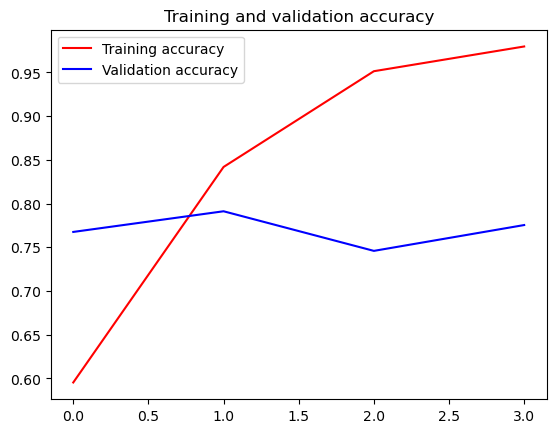

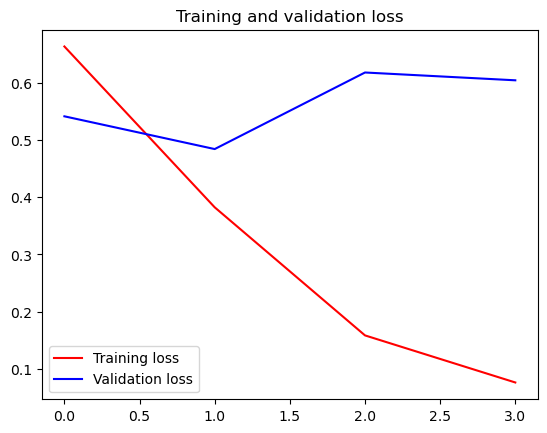

In [13]:
acc = fit_result.history['accuracy']
val_acc = fit_result.history['val_accuracy']
loss = fit_result.history['loss']
val_loss = fit_result.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In the model set up above, the fit maintains high accuracy and low loss over the first few epochs.

In [14]:
y_pred = model.predict(X_valid)
y_pred = y_pred.round().squeeze()

fpr, tpr, _ = roc_curve(y_valid, y_pred)
auc = auc(fpr, tpr)
auc

48/48 [==============================] - 0s 2ms/step


0.774968957941991

## Predicting for Submission
In order to predict from the test set of tweets, first the load those tweets.

In [15]:
tweets_test = pd.read_csv(f"{INPUT_DIR}/test.csv")

tweets_test.drop('keyword', axis=1, inplace=True, errors='ignore')
tweets_test.drop('location', axis=1, inplace=True, errors='ignore')
tweets_test.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


Now predict the presence of a natural disaster as indicated by those tweets.

In [16]:
pred = model.predict(tweets_test['text'])
pred = pred.round().squeeze()


102/102 [==============================] - 0s 2ms/step


## Saving the Submission
Finally, save the predictions to a dataframe, and ensure the columns offer values in the expected format.

First, observe that the submissions are in the following form.

In [17]:
sample_submission = pd.read_csv(f"{INPUT_DIR}/sample_submission.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [18]:
submissions_df = pd.DataFrame({'id': tweets_test['id'],
                            'target':pred})

# Convert the submissions dataframe columns to what we expect
submissions_df['id'] = submissions_df['id']
submissions_df['target'] = submissions_df['target'].astype('int8')
submissions_df.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


Save those submissions to a csv

In [19]:
submissions_df.to_csv("/kaggle/working/submission.csv", index=False, header=True)
print("Exported to CSV")

Exported to CSV


# Conclusion
In this study, we explored the use of natural language processing (NLP) to identify disaster tweets on Twitter. We found that NLP can be a powerful tool for this task, but it is important to consider the nuances of human language. For example, the word "ABLAZE" can be used literally or metaphorically, and it is important for a machine learning model to be able to distinguish between these two uses.

We built a model using NLP where the model architecture included vectorizing the input text, and then a few further hidden layers that improved accuracy and possibly overfit the model. We used a technique called regularization to help prevent overfitting, but it is possible that the model still overfit to the training data.

Overall, our findings suggest that NLP is a promising tool for identifying disaster tweets on Twitter. However, further research is needed to improve the accuracy of NLP models for this task.